# **READ ME:**

---

To run this, you will need to upload the "interview_dataset.csv" file onto your workspace. For my implementation, I used Google Colaboratory so that may be simplest.
Other than that, everything else should run on its own.

---

To summarize my work, I shifted through multiple algorithms, before settling on this one. At first, I tried working with an ANN trained to use prior values to predict future ones, however, this proved to be ineffective beyond a couple of points. I then experimented with univariate data models like ARIMA, but realized that a univariate model was not the correct model. Since the data contained multiple features affecting usage, I decided a multivariate time series model would be best. I ended up using a VAR (Vector Auto Regression) model, and was able to implement and fit it onto the data. I think the overall structure fits the problem well, and would work well for predicting into the future, as it is meant to excel at using each feature to help predict eachother. Unfortunately, in implementation, the model generalized greatly, as when graphed it largely rose to one value and stayed there. I predict that this is an error relating to stationarity, as this is something I've read is critical in confirming within time series. I don't have much experience with it, but there are plentiful resources online, and my first step would be to fix any stationarity issues to create better predictions.

In [0]:
#import initial packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
#read in data
df = pd.read_csv("interview_dataset.csv")
df.dtypes

datetime              object
USAGE_KWH            float64
DAY_OF_WEEK          float64
HOUR_OF_DAY          float64
VISIBILITY           float64
TEMP_F                 int64
TEMP_C               float64
RELATIVE_HUMIDITY      int64
dtype: object

In [0]:
#make the datetimes the index
df['datetime'] = pd.to_datetime(df.datetime)
data = df.drop(['datetime'], axis=1)
data.index = df.datetime

In [51]:
#new dataframe
data.head()

,USAGE_KWH,DAY_OF_WEEK,HOUR_OF_DAY,VISIBILITY,TEMP_F,TEMP_C,RELATIVE_HUMIDITY
datetime,,,,,,,
2016-01-01 00:00:00,8.870,4.0,0.0,10.0,45,7.3,80
2016-01-01 00:15:00,9.053,4.0,0.0,10.0,45,7.3,80
2016-01-01 00:30:00,8.746,4.0,0.0,10.0,45,7.3,80
2016-01-01 00:45:00,8.688,4.0,0.0,10.0,45,7.3,80
2016-01-01 01:00:00,9.062,4.0,1.0,10.0,45,7.0,77


In [53]:
#drop reduntant time-based columns because the date-time object already covers it
newdata = data.drop(['DAY_OF_WEEK'], axis = 1)
newdata = newdata.drop(['HOUR_OF_DAY'], axis = 1)
newdata.head()

,USAGE_KWH,VISIBILITY,TEMP_F,TEMP_C,RELATIVE_HUMIDITY
datetime,,,,,
2016-01-01 00:00:00,8.870,10.0,45,7.3,80
2016-01-01 00:15:00,9.053,10.0,45,7.3,80
2016-01-01 00:30:00,8.746,10.0,45,7.3,80
2016-01-01 00:45:00,8.688,10.0,45,7.3,80
2016-01-01 01:00:00,9.062,10.0,45,7.0,77


In [0]:
#remove null values
newdata.dropna(inplace=True)

In [55]:
#conduct test for stationarity - I didn't make any changes off this, and I feel that the dataset not being stationary may have been a cause of problems
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = newdata
coint_johansen(johan_test_temp,-1,1).eig

array([3.22429324e-02, 2.90661626e-02, 7.89635463e-03, 8.47539763e-04,
       6.94429931e-06])

In [0]:
#create train and test sets - these have to be in order with time
train = newdata[:int(0.8*(len(newdata)))]
valid = newdata[int(0.8*(len(newdata))):]

In [0]:
#import the Vector Auto Regression model
from statsmodels.tsa.vector_ar.var_model import VAR

In [58]:
#Fit the model to the training data
model = VAR(endog=train)
model_fit = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
#make a forecasted prediction on the length of the validation set
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [60]:
#the predicted values
prediction

array([[17.88137349,  9.95334881, 72.91097743, 22.50766392, 84.89893485],
       [17.88956131,  9.90794953, 72.84650894, 22.51440353, 84.78824625],
       [17.89936353,  9.86427152, 72.80020189, 22.52038983, 84.67146883],
       ...,
       [19.42947135,  9.44581972, 67.14291968, 19.47432933, 74.05046247],
       [19.42947134,  9.44581972, 67.14291942, 19.47432919, 74.05046237],
       [19.42947132,  9.44581973, 67.14291916, 19.47432904, 74.05046226]])

In [82]:
#convert the array to a data frame
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[newdata.columns])
for j in range(0,5):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check root mean squared error for numerical accuracy checking
for i in newdata.columns:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for USAGE_KWH is :  10.30616770851668
rmse value for VISIBILITY is :  2.2983347650263
rmse value for TEMP_F is :  14.057107238687415
rmse value for TEMP_C is :  7.791691903307459
rmse value for RELATIVE_HUMIDITY is :  19.562983763072413


In [63]:
#create copy of the validation set to use for the predictions
testgraph = valid.copy()
testgraph.head()

,USAGE_KWH,VISIBILITY,TEMP_F,TEMP_C,RELATIVE_HUMIDITY
datetime,,,,,
2016-10-19 19:15:00,18.384,10.0,73,22.5,85
2016-10-19 19:30:00,16.829,10.0,73,22.5,85
2016-10-19 19:45:00,20.266,10.0,73,22.5,85
2016-10-19 20:00:00,17.357,10.0,74,23.1,85
2016-10-19 20:15:00,12.346,10.0,74,23.1,85


In [0]:
#make an array of only the predicted values for usage_kwh
filtered_prediction = []
for pred in prediction:
  filtered_prediction.append(pred[0])
filtered_prediction

In [0]:
#replace the testgraph's usage_kwh values with the predictions
testgraph['USAGE_KWH'] = filtered_prediction

In [67]:
#check the change is complete
testgraph.head()

,USAGE_KWH,VISIBILITY,TEMP_F,TEMP_C,RELATIVE_HUMIDITY
datetime,,,,,
2016-10-19 19:15:00,17.881373,10.0,73,22.5,85
2016-10-19 19:30:00,17.889561,10.0,73,22.5,85
2016-10-19 19:45:00,17.899364,10.0,73,22.5,85
2016-10-19 20:00:00,17.910603,10.0,74,23.1,85
2016-10-19 20:15:00,17.923121,10.0,74,23.1,85


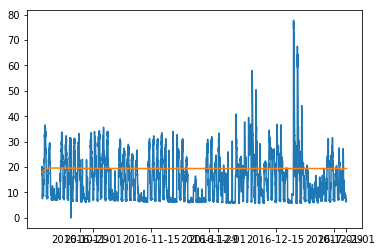

In [70]:
#compare the validation set to the predictions
#The graph shows that the model generalized heavily, and work will need to be done to improve it.
#I believe it was an issue with stationarity, which I will have to work more with to improve upon
plt.plot(valid['USAGE_KWH'])
plt.plot(testgraph['USAGE_KWH'])


In [84]:
#fitting the model on the full dataset, and predicting 96 datapoints into the future
model = VAR(endog=newdata)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=96)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
#making the predictions into a dataframe
predyhat = pd.DataFrame(index=range(0,len(yhat)),columns=[newdata.columns])
for j in range(0,5):
    for i in range(0, len(yhat)):
       predyhat.iloc[i][j] = yhat[i][j]

In [86]:
#checking it is indeed a dataframe
predyhat.head()

,USAGE_KWH,VISIBILITY,TEMP_F,TEMP_C,RELATIVE_HUMIDITY
0,6.89649,5.22158,65.029,18.392,90.1382
1,7.2405,5.4308,65.0499,18.3854,90.2608
2,7.57077,5.62817,65.0651,18.38,90.3678
3,7.88796,5.81422,65.0765,18.3757,90.4593
4,8.19272,5.98952,65.0853,18.3724,90.5358


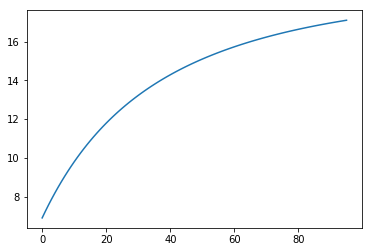

In [87]:
#plotting the predictions to see the results
#Again, the model clearly generalized greatly, and changes will need to be made to improve stationarity, and take into account seasonality
plt.plot(predyhat['USAGE_KWH'])